In [87]:
from dotenv import dotenv_values
from elasticsearch import Elasticsearch
from elasticsearch.helpers import bulk
import re
import timeit
import matplotlib.pyplot as plt
import numpy as np
import time

INDEX_NAME = 'cran'

In [88]:
config = dotenv_values('.env')
es_client = Elasticsearch(
    config['elasticsearch_uri'],
    ca_certs=config['ca_certificate'],
    basic_auth=(config['account'], config['password']),
)

In [89]:
class Text:

    def __init__(self, original):
        result = re.split(r'.T|.A|.B|.W', original.replace('\n', ' '))
        self.index, self.title, self.author, self.bibliography, self.body, *_ = result

    def source_dict(self):
        source = self.__dict__.copy()
        source.pop('index')
        return source

    def to_index_dict(self, index_name):
        return  {
            '_op_type': 'index',
            '_index': index_name,
            '_id': int(self.index),
            '_source': self.source_dict()
        }


class Query:

    def __init__(self, text):
        result = text.split('\n.W\n')
        self.index, self.body = map(lambda x: x.strip().replace('\n', ' '),
                                    result)

In [90]:
def parse_queries(filename):
    queries = []
    with open(filename, 'r') as file:
        txt = file.read()
        txt = txt.split('.I')[1:]
        queries = list(map(lambda x: Query(x), txt))
    return queries


def parse_text(filename):
    words = []
    with open(filename, 'r') as file:
        txt = file.read()
        txt = txt.split('.I')[1:]
        words = list(map(lambda x: Text(x), txt))
    return words


def parse_to_bulk(filename, index_name):
    return list(map(lambda x: x.to_index_dict(index_name), parse_text(filename)))


def get_ordered_relevant_searches(filename):
    query_relations = {}
    with open(filename, 'r') as file:
        txt = file.read()
        txt = txt.strip().split('\n')
        for i in txt:
            query, abstract, score = map(
                lambda x: int(x),
                filter(lambda x: len(x) > 0,
                       i.strip().split(' ')))
            if query - 1 not in query_relations:
                query_relations[query - 1] = [(abstract, score)]
            else:
                query_relations[query - 1].append((abstract, score))

    #ordenando as relations por rank
    for i in query_relations:
        query_relations[i].sort(key=lambda x: x[1])

    return query_relations

In [91]:
def search_results(index_name, client: Elasticsearch, queries: list[Query], limits: list[int], fields: list[str]):
    results_dict = {}
    for i, (limit, query) in enumerate(zip(limits, queries)):
        body = {
            'query': {
                "multi_match" : {
                    "query" : query.body,
                    "fields": fields
                }
            },
            'size': max(limit, 10)
        }
        response = client.search(index=index_name, body=body)
        results_dict[i] = list(map((lambda x: (int(x['_id']), x['_score'])), response['hits']['hits']))
    return results_dict

def search_results_one_field(index_name, client: Elasticsearch, queries: list[Query], limits: list[int], field: str):
    results_dict = {}
    for i, (limit, query) in enumerate(zip(limits, queries)):
        response = client.search(index=index_name, size=max(limit, 10), query={
            "match": {
                field: query.body,
            },
        })
        results_dict[i] = list(map((lambda x: (int(x['_id']), x['_score'])), response['hits']['hits']))
    return results_dict

In [92]:
def precision_at_k(answer, relevant, k=None):
    if k is None or k > len(answer) or k > len(relevant):
        k = min(len(answer), len(relevant))
    result = len(set(answer[:k]) & set(relevant)) / k if k != 0 else 0
    return result


def recall_at_k(answer, relevant, k=None):
    if k is None or k > len(answer) or k > len(relevant):
        k = min(len(answer), len(relevant))

    d = len(relevant)
    return len(set(answer[:k]) & set(relevant)) / d if d != 0 else 0

In [93]:
def all_results_by_func(answer_results_dict: dict,
                        relevant_results_dict: dict,
                        func,
                        k: int = None):
    size = len(relevant_results_dict)
    results = np.zeros(size)
    for i, (answer, relevant) in enumerate(
            zip(answer_results_dict.values(), relevant_results_dict.values())):
        answer = list(map(lambda x: x[0], answer))
        relevant = list(map(lambda x: x[0], relevant))
        results[i] = func(answer, relevant, k)
    return results


def plot_results(
        answer_results_dict,
        relevant_results_dict,
        func,
        k_s=range(1, 10 + 1),
        title: str = '',
):
    results = list(
        map(
            lambda k: all_results_by_func(
                answer_results_dict, relevant_results_dict, func, k).mean(),
            k_s))
    plt.plot(k_s, results, marker='o')
    plt.xlabel('K')
    plt.ylabel(f'{func.__name__} mean')
    plt.title(title)
    plt.show()

In [94]:
#OBTENDO QUERIES
queries = parse_queries('cran/cran.qry')

#OBTENDO PALAVRAS
words = parse_to_bulk('cran/cran.all.1400', INDEX_NAME)

#OBTENDO BUSCAS RELEVANTES
relevant_dict = get_ordered_relevant_searches('cran/cranqrel')

In [95]:
# METODO MUITO LENTO (~2m20s), PREFERIVEL USAR O BULK (~1.3s)
# t0 = timeit.default_timer()
# words = parse_text('cran/cran.all.1400')
# for word in tqdm(words2):
#     es_client.index(index=INDEX_NAME, id=int(word.index), body=word.source_dict())
# es_client.indices.delete(index=INDEX_NAME)
# t1 = timeit.default_timer()
# print(t1 - t0)

In [96]:
#INDEXANDO RESULTADOS
t0 = timeit.default_timer()
es_client.indices.create(index=INDEX_NAME)
bulk(client=es_client, actions=words)
while int(
            es_client.cat.indices(
                index=INDEX_NAME,
                format='json')[0]['docs.count']) != len(words):
        time.sleep(0.2)
t1 = timeit.default_timer()
print(f'TEMPO DE INDEXAÇÃO = {(t1 - t0):.2f}s')

TEMPO DE INDEXAÇÃO = 2.07s


In [97]:
limits = list(map(lambda x: len(x), relevant_dict.values()))

In [98]:
#BUSCA 1: TITULO, AUTOR E CORPO
t0 = timeit.default_timer()
results_1 = search_results(INDEX_NAME, es_client, queries, limits, ["title", "author", "body"])
t1 = timeit.default_timer()
print(f'TEMPO DA BUSCA 1 = {(t1 - t0):.2f}s')

TEMPO DA BUSCA 1 = 0.50s


In [99]:
#BUSCA 2: SOMENTE CORPO
t0 = timeit.default_timer()
results_2 = search_results_one_field(INDEX_NAME, es_client, queries, limits, "body")
t1 = timeit.default_timer()
print(f'TEMPO DA BUSCA 1 = {(t1 - t0):.2f}s')

TEMPO DA BUSCA 1 = 0.36s


In [100]:
K_S = range(1, 11)

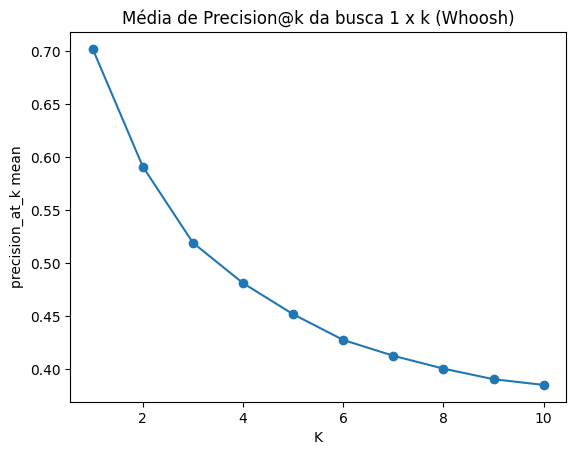

In [101]:
#PLOTANDO GRAFICO DE PRECISION DA BUSCA 1
plot_results(results_1,
             relevant_dict,
             precision_at_k,
             k_s=K_S,
             title='Média de Precision@k da busca 1 x k (Elasticsearch)')

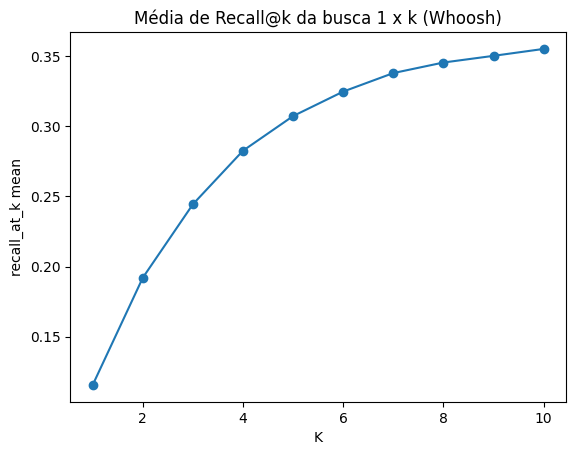

In [102]:

#PLOTANDO GRAFICO DE RECALL DA BUSCA 1
plot_results(results_1,
             relevant_dict,
             recall_at_k,
             k_s=K_S,
             title='Média de Recall@k da busca 1 x k (Elasticsearch)')

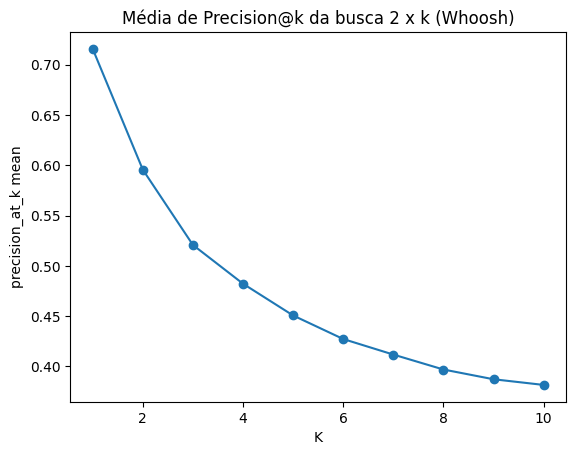

In [103]:
#PLOTANDO GRAFICO DE PRECISION DA BUSCA 2
plot_results(results_2,
             relevant_dict,
             precision_at_k,
             k_s=K_S,
             title='Média de Precision@k da busca 2 x k (Elasticsearch)')

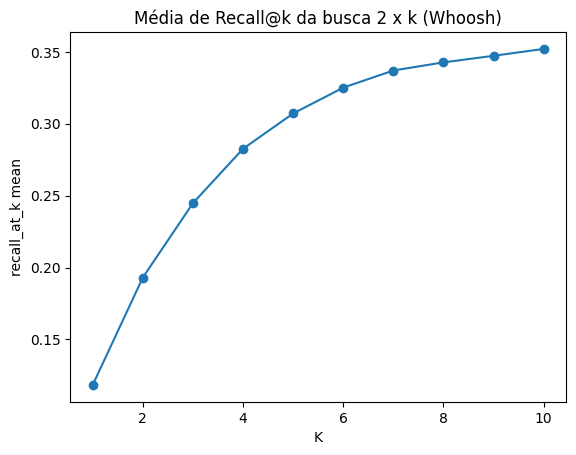

In [104]:
#PLOTANDO GRAFICO DE RECALL DA BUSCA 2
plot_results(results_2,
             relevant_dict,
             recall_at_k,
             k_s=K_S,
             title='Média de Recall@k da busca 2 x k (Elasticsearch)')

In [105]:
es_client.indices.delete(index=INDEX_NAME)

ObjectApiResponse({'acknowledged': True})